# eDMFT Calculations for Energy Thresholds

Ubuntu 25.04 for ARM64
Python 3.9.23 via Conda

## 1. Dependencies and imports

In [1]:
import sys, importlib, shutil, subprocess, os, tempfile, random

# check Python packages
print("Checking Python packages...")
packages = ["numpy", "ase", "jarvis", "triqs", "nglview", "seaborn"]
for pkg in packages:
    try:
        importlib.import_module(pkg)
        print(f"  ✓ {pkg}")
    except ImportError:
        print(f"  ✗ {pkg} - NOT FOUND")

# test TRIQS runtime
try:
    from triqs.gf import GfImFreq
    GfImFreq(beta=10.0, n_points=8, indices=range(2))
    print("  ✓ TRIQS runtime working")
except Exception as e:
    print(f"  ✗ TRIQS runtime failed: {e}")

print()

# Check executables - make sure they are in PATH
print("Checking executables...")
executables = ["pw.x", "wannier90.x", "pw2wannier90.x", "mpirun"]
for exe in executables:
    found = shutil.which(exe)
    if found:
        print(f"  ✓ {exe:<20} → {found}")
    else:
        print(f"  ✗ {exe:<20} - NOT IN PATH")

print()

# check pseudopotential directory
print("Checking pseudopotentials...")
pseudo_dir = "/usr/share/espresso/pseudo"
if os.path.isdir(pseudo_dir):
    num_pseudos = len([f for f in os.listdir(pseudo_dir) if f.endswith(('.upf', '.UPF'))])
    print(f"  ✓ {pseudo_dir}")
    print(f"    Found {num_pseudos} pseudopotential files")
else:
    print(f"  ✗ {pseudo_dir} - NOT FOUND")

Checking Python packages...
  ✓ numpy
  ✓ ase
  ✓ jarvis
  ✓ triqs


  ✓ nglview
  ✓ seaborn
  ✓ TRIQS runtime working

Checking executables...
  ✓ pw.x                 → /home/vm/miniconda3/envs/DSI/bin/pw.x
  ✓ wannier90.x          → /home/vm/miniconda3/envs/DSI/bin/wannier90.x
  ✓ pw2wannier90.x       → /home/vm/miniconda3/envs/DSI/bin/pw2wannier90.x
  ✓ mpirun               → /usr/bin/mpirun

Checking pseudopotentials...
  ✓ /usr/share/espresso/pseudo
    Found 103 pseudopotential files


In [2]:
import numpy as np
from jarvis.db.figshare import data as jarvis_data
from jarvis.core.atoms import Atoms as JarvisAtoms
from ase import Atoms as AseAtoms
from triqs.gf import GfImFreq, BlockGf
import nglview as nv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyBboxPatch
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.titlesize'] = 13

## 2. Config

In [3]:
# database
JARVIS_DATABASE = "dft_3d"

# working directory
WORK_DIR = os.path.join(os.getcwd(), "calculations")
os.makedirs(WORK_DIR, exist_ok=True)

# pseudopotentials directory
QE_PSEUDOPOTENTIALS_DIR = pseudo_dir

# executables (resolved from PATH)
QE_EXECUTABLE = shutil.which("pw.x") or shutil.which("pw")
WANNIER90_EXECUTABLE = shutil.which("wannier90.x") or shutil.which("wannier90")
PW2WANNIER90_EXECUTABLE = shutil.which("pw2wannier90.x") or shutil.which("pw2wannier90")
MPI_EXECUTABLE = shutil.which("mpirun") or shutil.which("mpiexec")

# params
QE_NPROCS = 8
QE_TIMEOUT = 600

# DFT params
ECUTWFC = 30.0
ECUTRHO = 120.0
K_POINTS = [2, 2, 2]
OCCUPATIONS = "smearing"
SMEARING = "gaussian"
DEGAUSS = 0.02

# wanneir params
NUM_WANNIER_FUNCTIONS = 10

# eDMFT params
HUBBARD_U = 4.0
TRIQS_BETA = 40.0
DMFT_ITERATIONS = 20

# energy thresholds
DISPLACEMENT_THRESHOLD_EV = 25.0
PKA_ENERGY_THRESHOLD_EV = 100.0

print("Configuration resolved:")
print(f"{'Parameter':<30} {'Value':<60}")
print(f"{'-'*30} {'-'*60}")
print(f"{'WORK_DIR':<30} {WORK_DIR:<60}")
print(f"{'JARVIS_DATABASE':<30} {JARVIS_DATABASE:<60}")
print(f"{'QE_PSEUDOPOTENTIALS_DIR':<30} {QE_PSEUDOPOTENTIALS_DIR:<60}")
print(f"{'QE_EXECUTABLE':<30} {QE_EXECUTABLE:<60}")
print(f"{'MPI_EXECUTABLE':<30} {MPI_EXECUTABLE:<60}")
print(f"{'WANNIER90_EXECUTABLE':<30} {WANNIER90_EXECUTABLE:<60}")
print(f"{'PW2WANNIER90_EXECUTABLE':<30} {PW2WANNIER90_EXECUTABLE:<60}")
print(f"{'QE_NPROCS':<30} {QE_NPROCS:<60}")
print(f"{'ECUTWFC':<30} {ECUTWFC:<60}")
print(f"{'NUM_WANNIER_FUNCTIONS':<30} {NUM_WANNIER_FUNCTIONS:<60}")
print(f"{'DMFT_ITERATIONS':<30} {DMFT_ITERATIONS:<60}")

Configuration resolved:
Parameter                      Value                                                       
------------------------------ ------------------------------------------------------------
WORK_DIR                       /home/vm/DSI_Project3/calculations                          
JARVIS_DATABASE                dft_3d                                                      
QE_PSEUDOPOTENTIALS_DIR        /usr/share/espresso/pseudo                                  
QE_EXECUTABLE                  /home/vm/miniconda3/envs/DSI/bin/pw.x                       
MPI_EXECUTABLE                 /usr/bin/mpirun                                             
WANNIER90_EXECUTABLE           /home/vm/miniconda3/envs/DSI/bin/wannier90.x                
PW2WANNIER90_EXECUTABLE        /home/vm/miniconda3/envs/DSI/bin/pw2wannier90.x             
QE_NPROCS                      8                                                           
ECUTWFC                        30.0                     

## 3. Load Material from JARVIS

In [4]:
data = jarvis_data(JARVIS_DATABASE)
mat = random.choice(data)
MATERIAL_ID = mat.get('jid')

jarvis_atoms = JarvisAtoms.from_dict(mat['atoms'])
ase_atoms = AseAtoms(
    symbols=jarvis_atoms.elements,
    positions=jarvis_atoms.cart_coords,
    cell=jarvis_atoms.lattice_mat,
    pbc=True
)

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.


In [5]:
# extract detailed material information
elements = list(set(ase_atoms.get_chemical_symbols()))
element_counts = {e: ase_atoms.get_chemical_symbols().count(e) for e in elements}
cell_volume = ase_atoms.get_volume()
density = sum(ase_atoms.get_masses()) / cell_volume

print(f"Selected Material: {MATERIAL_ID}")
print(f"{'Property':<30} {'Value':<40}")
print(f"{'-'*30} {'-'*40}")
print(f"{'Chemical Formula':<30} {ase_atoms.get_chemical_formula():<40}")
print(f"{'Total Atoms':<30} {len(ase_atoms):<40}")
print(f"{'Unique Elements':<30} {', '.join(sorted(elements)):<40}")
print(f"{'Element Composition':<30} {str(element_counts):<40}")
print(f"{'Cell Volume':<30} {cell_volume} Å³")
print(f"{'Density':<30} {density} amu/Å³")

# cell parameters
cell_lengths = ase_atoms.cell.lengths()
cell_angles = ase_atoms.cell.angles()
print(f"{'Cell Lengths (a,b,c)':<30} {cell_lengths[0]}, {cell_lengths[1]}, {cell_lengths[2]} Å")
print(f"{'Cell Angles (α,β,γ)':<30} {cell_angles[0]}°, {cell_angles[1]}°, {cell_angles[2]}°")

# additional JARVIS metadata if available
if 'formation_energy_peratom' in mat:
    print(f"{'Formation Energy':<30} {mat['formation_energy_peratom']} eV/atom")
if 'optb88vdw_bandgap' in mat:
    print(f"{'Band Gap (OptB88vdW)':<30} {mat['optb88vdw_bandgap']} eV")
if 'spillage' in mat:
    print(f"{'Spillage':<30} {mat['spillage']}")
if 'kpoint_length_unit' in mat:
    print(f"{'K-point Length Unit':<30} {mat['kpoint_length_unit']}")

Selected Material: JVASP-93207
Property                       Value                                   
------------------------------ ----------------------------------------
Chemical Formula               CLiMg6                                  
Total Atoms                    8                                       
Unique Elements                C, Li, Mg                               
Element Composition            {'Mg': 6, 'C': 1, 'Li': 1}              
Cell Volume                    150.8543811805677 Å³
Density                        1.092318292053862 amu/Å³
Cell Lengths (a,b,c)           6.654802209655885, 6.654800756505985, 3.4575528789132877 Å
Cell Angles (α,β,γ)            90.0°, 90.0°, 99.87391852593343°
Formation Energy               0.19968 eV/atom
Band Gap (OptB88vdW)           0.0 eV
Spillage                       na
K-point Length Unit            110


In [6]:
material_data = {
    'material_id': MATERIAL_ID,
    'symbols': ase_atoms.get_chemical_symbols(),
    'positions': ase_atoms.positions.tolist(),
    'cell': ase_atoms.cell.tolist(),
    'formula': ase_atoms.get_chemical_formula(),
}

In [7]:
from ase.build import make_supercell
supercell = make_supercell(ase_atoms, [[2, 0, 0], [0, 2, 0], [0, 0, 2]])
view = nv.show_ase(supercell)
view.add_unitcell()
view.center()
display(view)

NGLWidget()

## 4. Generate Quantum ESPRESSO Input Files (SCF & NSCF)

In [8]:
elements = list(set(ase_atoms.get_chemical_symbols()))
pseudos = {}
for e in elements:
    candidates = [f for f in os.listdir(QE_PSEUDOPOTENTIALS_DIR) 
                  if f.startswith(e+'.') or f.startswith(e+'_') or 
                     f.startswith(e.lower()+'.') or f.startswith(e.lower()+'_')]
    pseudos[e] = candidates[0]

print(f"Material: {MATERIAL_ID}")
print(f"Elements: {elements}")
print(f"Pseudopotentials: {list(pseudos.values())}")

# generate k-points for nscf (explicit, wannier90-compatible)
nk_nscf = [K_POINTS[0]*2, K_POINTS[1]*2, K_POINTS[2]*2]
nkpts_nscf = nk_nscf[0] * nk_nscf[1] * nk_nscf[2]
kpoints_nscf = []
for k in range(nk_nscf[2]):
    for j in range(nk_nscf[1]):
        for i in range(nk_nscf[0]):
            kpoints_nscf.append([i/nk_nscf[0], j/nk_nscf[1], k/nk_nscf[2]])

def generate_qe_input(calc_type, k_grid, atoms, material_id, pseudos, nbnd=None):
    lines = []
    lines.append(f"&CONTROL\n  calculation='{calc_type}'\n  prefix='{material_id}'\n")
    lines.append(f"  outdir='./tmp'\n  pseudo_dir='{QE_PSEUDOPOTENTIALS_DIR}'\n/\n")
    lines.append(f"&SYSTEM\n  ibrav=0\n  nat={len(atoms)}\n  ntyp={len(elements)}\n")
    lines.append(f"  ecutwfc={ECUTWFC}\n  ecutrho={ECUTRHO}\n")
    lines.append(f"  occupations='{OCCUPATIONS}'\n  smearing='{SMEARING}'\n  degauss={DEGAUSS}\n")
    if calc_type == 'nscf':
        lines.append("  nosym=.true.\n  noinv=.true.\n")
        # Set nbnd if provided, otherwise let QE auto-calculate
        if nbnd is not None:
            lines.append(f"  nbnd={nbnd}\n")
    lines.append("/\n&ELECTRONS\n  conv_thr=1.0d-6\n/\nATOMIC_SPECIES\n")
    for e in elements:
        mass = atoms.get_masses()[atoms.get_chemical_symbols().index(e)]
        lines.append(f"  {e}  {mass:.4f}  {pseudos[e]}\n")
    lines.append("\nCELL_PARAMETERS angstrom\n")
    for i in range(3):
        lines.append(f"  {atoms.cell[i,0]:16.10f} {atoms.cell[i,1]:16.10f} {atoms.cell[i,2]:16.10f}\n")
    lines.append("\nATOMIC_POSITIONS angstrom\n")
    for s, p in zip(atoms.get_chemical_symbols(), atoms.positions):
        lines.append(f"  {s:4s} {p[0]:16.10f} {p[1]:16.10f} {p[2]:16.10f}\n")
    if calc_type == 'scf':
        lines.append(f"\nK_POINTS automatic\n  {k_grid[0]} {k_grid[1]} {k_grid[2]}  0 0 0\n")
    else:
        lines.append(f"\nK_POINTS crystal\n  {nkpts_nscf}\n")
        for kpt in kpoints_nscf:
            lines.append(f"  {kpt[0]:16.10f} {kpt[1]:16.10f} {kpt[2]:16.10f}  1.0\n")
    return ''.join(lines)

# Generate SCF input
qe_scf_input = generate_qe_input('scf', K_POINTS, ase_atoms, MATERIAL_ID, pseudos)

# Generate initial NSCF input (will regenerate after SCF with correct nbnd)
qe_nscf_input = generate_qe_input('nscf', nk_nscf, ase_atoms, MATERIAL_ID, pseudos)

print("QE input files generated (stored in memory)")
print(f"  SCF input: {len(qe_scf_input)} chars")
print(f"  NSCF input: {len(qe_nscf_input)} chars")
print(f"  Note: NSCF will auto-calculate nbnd initially")

Material: JVASP-93207
Elements: ['Mg', 'C', 'Li']
Pseudopotentials: ['Mg.pbe-n-kjpaw_psl.0.3.0.UPF', 'C.pbe-n-kjpaw_psl.1.0.0.UPF', 'li_pbe_v1.4.uspp.F.UPF']
QE input files generated (stored in memory)
  SCF input: 1123 chars
  NSCF input: 4854 chars
  Note: NSCF will auto-calculate nbnd initially


## 5. Run DFT Calculations

In [9]:
def run_streaming(cmd, cwd, timeout=None):
    process = subprocess.Popen(
        cmd,
        shell=True,
        cwd=cwd,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
        bufsize=1
    )
    output_lines = []
    for line in process.stdout:
        print(line, end='', flush=True)
        output_lines.append(line)
    
    process.wait(timeout=timeout)
    return ''.join(output_lines), process.returncode

# create material-specific directory in persistent location
dft_tmp_dir = os.path.join(WORK_DIR, f"dft_{MATERIAL_ID}")
os.makedirs(dft_tmp_dir, exist_ok=True)
print(f"Running DFT in: {dft_tmp_dir}\n")

scf_input_path = os.path.join(dft_tmp_dir, f"{MATERIAL_ID}_scf.in")
with open(scf_input_path, 'w') as f:
    f.write(qe_scf_input)

scf_output, _ = run_streaming(
    f"{MPI_EXECUTABLE} -np {QE_NPROCS} {QE_EXECUTABLE} -in {MATERIAL_ID}_scf.in",
    cwd=dft_tmp_dir,
    timeout=QE_TIMEOUT
)

# Extract number of bands from SCF output to use for NSCF
import re
nbnd_match = re.search(r'number of Kohn-Sham states\s*=\s*(\d+)', scf_output)
if nbnd_match:
    scf_nbnd = int(nbnd_match.group(1))
    # Use enough bands for Wannier90 but ensure it's reasonable
    nscf_nbnd = max(scf_nbnd, NUM_WANNIER_FUNCTIONS * 3)
    print(f"\nSCF used {scf_nbnd} bands")
    print(f"Setting NSCF to {nscf_nbnd} bands (max of SCF and {NUM_WANNIER_FUNCTIONS * 3})\n")
else:
    # Fallback: use a safe number
    nscf_nbnd = NUM_WANNIER_FUNCTIONS * 4
    print(f"\nCouldn't extract nbnd from SCF, using conservative value: {nscf_nbnd}\n")

# Regenerate NSCF input with correct nbnd
qe_nscf_input = generate_qe_input('nscf', nk_nscf, ase_atoms, MATERIAL_ID, pseudos, nbnd=nscf_nbnd)

nscf_input_path = os.path.join(dft_tmp_dir, f"{MATERIAL_ID}_nscf.in")
with open(nscf_input_path, 'w') as f:
    f.write(qe_nscf_input)

nscf_output, _ = run_streaming(
    f"{MPI_EXECUTABLE} -np {QE_NPROCS} {QE_EXECUTABLE} -in {MATERIAL_ID}_nscf.in",
    cwd=dft_tmp_dir,
    timeout=QE_TIMEOUT
)

Running DFT in: /home/vm/DSI_Project3/calculations/dft_JVASP-93207

[vm-QEMU-Virtual-Machine][[59497,1],1][../../../../../../opal/mca/btl/tcp/btl_tcp_proc.c:266:mca_btl_tcp_proc_create_interface_graph] Unable to find reachable pairing between local and remote interfaces
[vm-QEMU-Virtual-Machine][[59497,1],1][../../../../../../opal/mca/btl/tcp/btl_tcp_proc.c:266:mca_btl_tcp_proc_create_interface_graph] Unable to find reachable pairing between local and remote interfaces
[vm-QEMU-Virtual-Machine][[59497,1],1][../../../../../../opal/mca/btl/tcp/btl_tcp_proc.c:266:mca_btl_tcp_proc_create_interface_graph] Unable to find reachable pairing between local and remote interfaces
[vm-QEMU-Virtual-Machine][[59497,1],1][../../../../../../opal/mca/btl/tcp/btl_tcp_proc.c:266:mca_btl_tcp_proc_create_interface_graph] Unable to find reachable pairing between local and remote interfaces
[vm-QEMU-Virtual-Machine][[59497,1],1][../../../../../../opal/mca/btl/tcp/btl_tcp_proc.c:266:mca_btl_tcp_proc_create_int

In [10]:
dft_results = {
    'scf_output': scf_output[:5000] + '...(truncated)' if len(scf_output) > 5000 else scf_output,
    'nscf_output': nscf_output[:5000] + '...(truncated)' if len(nscf_output) > 5000 else nscf_output,
    'tmp_dir': dft_tmp_dir
}

print("DFT results stored in notebook")

DFT results stored in notebook


## 6. Generate Wannier90 Input

In [11]:
seedname = "wan"
nk = [K_POINTS[0]*2, K_POINTS[1]*2, K_POINTS[2]*2]
nkpts = nk[0] * nk[1] * nk[2]
kpoints = []
for k in range(nk[2]):
    for j in range(nk[1]):
        for i in range(nk[0]):
            kpoints.append([i/nk[0], j/nk[1], k/nk[2]])

wannier_input_lines = []
wannier_input_lines.append(f"num_wann = {NUM_WANNIER_FUNCTIONS}\n")
wannier_input_lines.append(f"num_bands = {nscf_nbnd}\n")  # Use actual nbnd from NSCF
wannier_input_lines.append("num_iter = 100\n")
wannier_input_lines.append("write_hr = true\n")
print(f"Wannier90 will use num_wann={NUM_WANNIER_FUNCTIONS}, num_bands={nscf_nbnd}")
wannier_input_lines.append("begin projections\nrandom\nend projections\n")
wannier_input_lines.append("begin unit_cell_cart\nang\n")
for i in range(3):
    wannier_input_lines.append(f"{ase_atoms.cell[i,0]:16.10f} {ase_atoms.cell[i,1]:16.10f} {ase_atoms.cell[i,2]:16.10f}\n")
wannier_input_lines.append("end unit_cell_cart\n")
wannier_input_lines.append("begin atoms_frac\n")
for s, p in zip(ase_atoms.get_chemical_symbols(), ase_atoms.get_scaled_positions()):
    wannier_input_lines.append(f"{s} {p[0]:.10f} {p[1]:.10f} {p[2]:.10f}\n")
wannier_input_lines.append("end atoms_frac\n")
wannier_input_lines.append(f"mp_grid = {nk[0]} {nk[1]} {nk[2]}\n")
wannier_input_lines.append("begin kpoints\n")
for kpt in kpoints:
    wannier_input_lines.append(f"{kpt[0]:16.10f} {kpt[1]:16.10f} {kpt[2]:16.10f}\n")
wannier_input_lines.append("end kpoints\n")

wannier_input = ''.join(wannier_input_lines)
print("Wannier90 input generated (stored in memory)")

Wannier90 will use num_wann=10, num_bands=30
Wannier90 input generated (stored in memory)


## 7. Run Wannier90 Workflow

In [12]:
# create wannier-specific directory in persistent location
wan_tmpdir = os.path.join(WORK_DIR, f"wannier_{MATERIAL_ID}")
os.makedirs(wan_tmpdir, exist_ok=True)
print(f"Running Wannier90 in: {wan_tmpdir}\n")

win_file = os.path.join(wan_tmpdir, f"{seedname}.win")
with open(win_file, 'w') as f:
    f.write(wannier_input)

pp_output, _ = run_streaming(f"{WANNIER90_EXECUTABLE} -pp {seedname}", cwd=wan_tmpdir)

pw2wan_input = f"""&inputpp
  outdir = '{dft_tmp_dir}/tmp'
  prefix = '{MATERIAL_ID}'
  seedname = '{seedname}'
  write_mmn = .true.
  write_amn = .true.
  write_unk = .false.
/
"""
pw2wan_file = os.path.join(wan_tmpdir, "pw2wan.in")
with open(pw2wan_file, 'w') as f:
    f.write(pw2wan_input)

pw2wan_output, _ = run_streaming(f"{PW2WANNIER90_EXECUTABLE} < pw2wan.in", cwd=wan_tmpdir)

wannier_output, _ = run_streaming(f"{WANNIER90_EXECUTABLE} {seedname}", cwd=wan_tmpdir)

hr_file = os.path.join(wan_tmpdir, f"{seedname}_hr.dat")
if not os.path.exists(hr_file):
    print(f"\nError: {seedname}_hr.dat not found!")
    print(f"Contents of {wan_tmpdir}:")
    for item in os.listdir(wan_tmpdir):
        print(f"  {item}")
    raise FileNotFoundError(f"Wannier90 did not generate {seedname}_hr.dat")
    
with open(hr_file, 'r') as f:
    hr_data = f.read()

Running Wannier90 in: /home/vm/DSI_Project3/calculations/wannier_JVASP-93207


     Program PW2WANNIER v.7.3.1 starts on 12Oct2025 at 19: 6:57 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Parallel version (MPI & OpenMP), running on      10 processor cores
     Number of MPI processes:                 1
     Threads/MPI process:                    10

     MPI processes distributed on     1 nodes
     5505 MiB available memory on the printing compute node when the environment starts


     Reading nscf_save data

     Reading x

In [13]:
wannier_results = {
    'output': wannier_output[:5000] + '...(truncated)' if len(wannier_output) > 5000 else wannier_output,
    'hr_dat': hr_data
}

print("Wannier90 results stored in notebook")
print(f"  HR data: {len(hr_data)} chars")

Wannier90 results stored in notebook
  HR data: 475543 chars


## 8. Parse Tight-Binding Hamiltonian

In [14]:
lines = hr_data.split('\n')
num_wann = int(lines[1].strip())
nrpts = int(lines[2].strip())
ndegen_lines = (nrpts + 14) // 15

h_local = np.zeros((num_wann, num_wann), dtype=complex)
for line in lines[3+ndegen_lines:]:
    parts = line.split()
    if len(parts) >= 7 and all(int(parts[i]) == 0 for i in range(3)):
        i, j = int(parts[3])-1, int(parts[4])-1
        h_local[i, j] = float(parts[5]) + 1j*float(parts[6])

h_local = 0.5 * (h_local + h_local.conj().T)
dft_energy = np.real(np.trace(h_local))

print(f"Parsed tight-binding Hamiltonian: {num_wann}×{num_wann}")
print(f"DFT energy (trace): {dft_energy:.6f} eV")

# Store for visualization
h_local_dft = h_local.copy()

Parsed tight-binding Hamiltonian: 10×10
DFT energy (trace): 31.729714 eV


### Visualization: Tight-Binding Hamiltonian Matrix

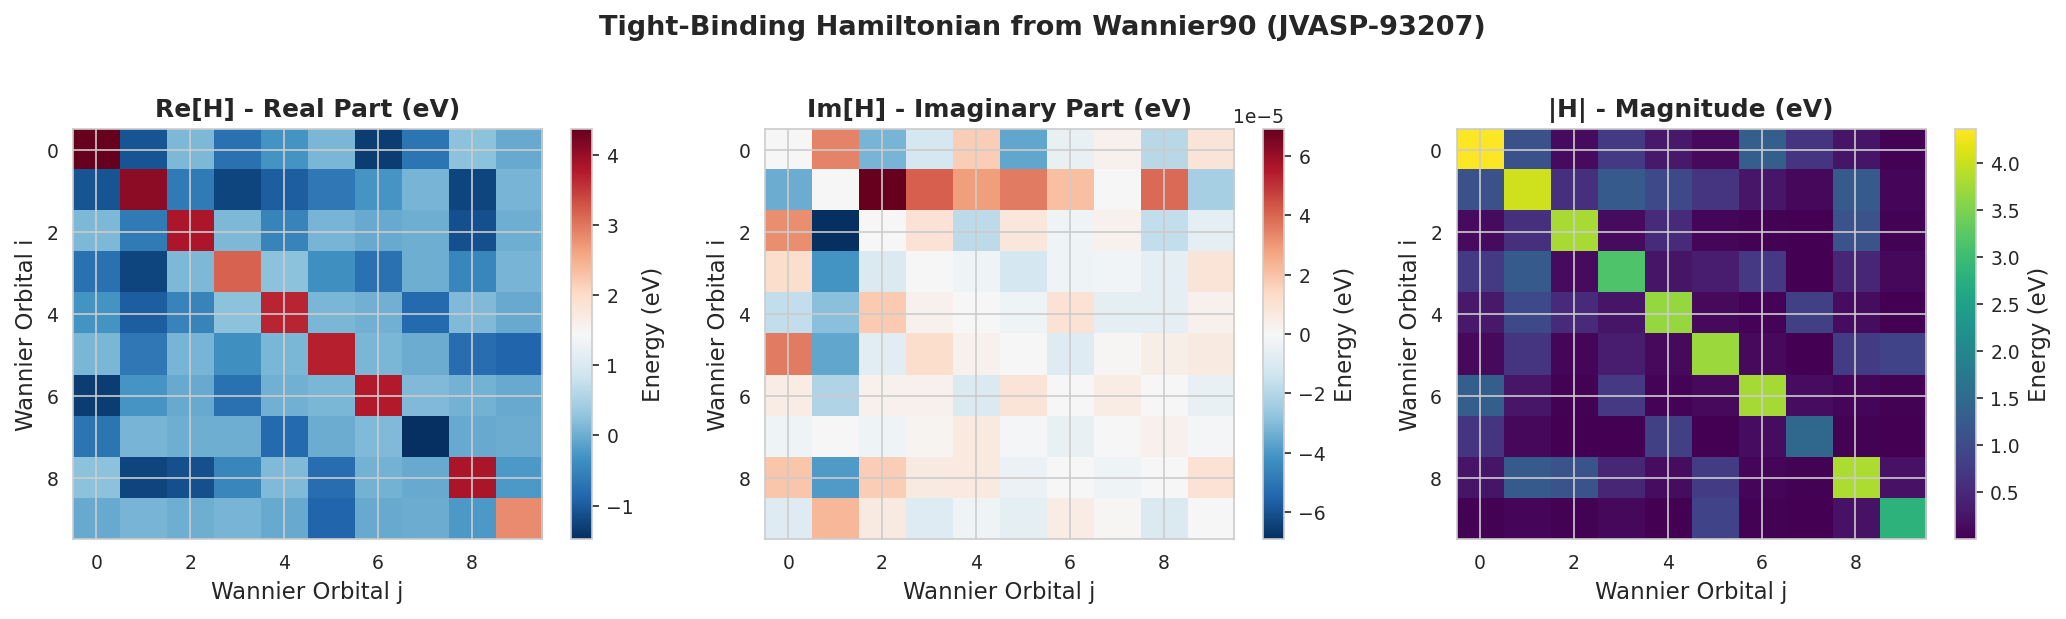

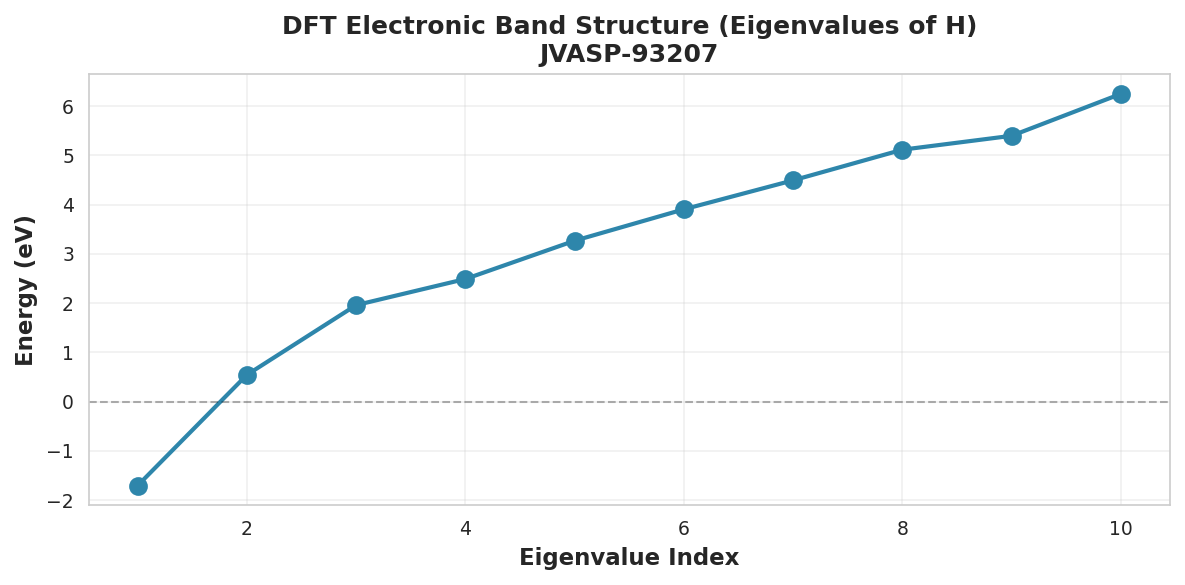

Eigenvalue range: [-1.702, 6.250] eV
Bandwidth: 7.952 eV


In [15]:
# Visualize the tight-binding Hamiltonian from DFT+Wannier90
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Real part
im1 = axes[0].imshow(np.real(h_local), cmap='RdBu_r', aspect='auto')
axes[0].set_title('Re[H] - Real Part (eV)', fontweight='bold')
axes[0].set_xlabel('Wannier Orbital j')
axes[0].set_ylabel('Wannier Orbital i')
plt.colorbar(im1, ax=axes[0], label='Energy (eV)')

# Imaginary part
im2 = axes[1].imshow(np.imag(h_local), cmap='RdBu_r', aspect='auto')
axes[1].set_title('Im[H] - Imaginary Part (eV)', fontweight='bold')
axes[1].set_xlabel('Wannier Orbital j')
axes[1].set_ylabel('Wannier Orbital i')
plt.colorbar(im2, ax=axes[1], label='Energy (eV)')

# Absolute value
im3 = axes[2].imshow(np.abs(h_local), cmap='viridis', aspect='auto')
axes[2].set_title('|H| - Magnitude (eV)', fontweight='bold')
axes[2].set_xlabel('Wannier Orbital j')
axes[2].set_ylabel('Wannier Orbital i')
plt.colorbar(im3, ax=axes[2], label='Energy (eV)')

plt.suptitle(f'Tight-Binding Hamiltonian from Wannier90 ({MATERIAL_ID})', 
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Eigenvalue spectrum
eigenvalues = np.linalg.eigvalsh(h_local)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(range(1, num_wann+1), eigenvalues, 'o-', linewidth=2, markersize=8, color='#2E86AB')
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
ax.set_xlabel('Eigenvalue Index', fontweight='bold')
ax.set_ylabel('Energy (eV)', fontweight='bold')
ax.set_title(f'DFT Electronic Band Structure (Eigenvalues of H)\n{MATERIAL_ID}', 
             fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Eigenvalue range: [{eigenvalues.min():.3f}, {eigenvalues.max():.3f}] eV")
print(f"Bandwidth: {eigenvalues.max() - eigenvalues.min():.3f} eV")

## 9. eDMFT Calculation

In [16]:
print(f"Setting up simplified eDMFT calculation...")
print(f"  Beta (inverse temperature): {TRIQS_BETA} eV⁻¹")
print(f"  Hubbard U: {HUBBARD_U} eV")
print(f"  Number of Wannier orbitals: {num_wann}")
print(f"  DMFT iterations: {DMFT_ITERATIONS}")
print()

# Initialize Green's functions with TRIQS
n_iw = 1025
G_iw = BlockGf(name_list=['up', 'down'], 
               block_list=[GfImFreq(beta=TRIQS_BETA, n_points=n_iw, indices=range(num_wann)) for _ in range(2)])

Sigma_iw = BlockGf(name_list=['up', 'down'],
                   block_list=[GfImFreq(beta=TRIQS_BETA, n_points=n_iw, indices=range(num_wann)) for _ in range(2)])

# Initialize to zero
Sigma_iw.zero()

# Chemical potential
mu = np.real(np.trace(h_local)) / num_wann
print(f"  Initial chemical potential μ = {mu:.4f} eV\n")

# Simple DMFT loop using Hartree-Fock self-energy
print("Running DMFT self-consistency loop...")
convergence_threshold = 1e-4
mixing = 0.5
convergence_history = []

for iteration in range(DMFT_ITERATIONS):
    print(f"Iteration {iteration+1}/{DMFT_ITERATIONS}:", flush=True)
    
    Sigma_iw_old = Sigma_iw.copy()
    
    # Calculate G from Dyson equation: G = [iω + μ - H - Σ]^{-1}
    for spin in ['up', 'down']:
        for n, iw in enumerate(G_iw[spin].mesh):
            omega_n = 1j * iw.value
            G_iw[spin].data[n, :, :] = np.linalg.inv(
                (omega_n + mu) * np.eye(num_wann) - h_local - Sigma_iw[spin].data[n, :, :]
            )
    
    # Extract occupations from Matsubara sum (avoiding tail fitting issues)
    # n = (1/β) Σ_n G(iω_n) + (1/2)  (standard formula)
    occupations = {}
    for spin in ['up', 'down']:
        occ_matrix = np.zeros((num_wann, num_wann), dtype=complex)
        for n, iw in enumerate(G_iw[spin].mesh):
            occ_matrix += G_iw[spin].data[n, :, :]
        occ_matrix = (1.0/TRIQS_BETA) * occ_matrix + 0.5 * np.eye(num_wann)
        occupations[spin] = np.real(np.diag(occ_matrix))
        print(f"  <n_{spin}> = {np.mean(occupations[spin]):.4f}", flush=True)
    
    # Update self-energy: Σ_σ(iω) = U * n_{-σ} (Hartree-Fock)
    for spin in ['up', 'down']:
        other_spin = 'down' if spin == 'up' else 'up'
        for orb in range(num_wann):
            # Constant self-energy (Hartree approximation)
            Sigma_iw[spin].data[:, orb, orb] = HUBBARD_U * occupations[other_spin][orb]
    
    # Mix for stability
    Sigma_iw << mixing * Sigma_iw + (1 - mixing) * Sigma_iw_old
    
    # Check convergence
    diff = np.max([np.max(np.abs(Sigma_iw[spin].data - Sigma_iw_old[spin].data)) for spin in ['up', 'down']])
    print(f"  |ΔΣ| = {diff:.2e}")
    
    # Store convergence data
    convergence_history.append({
        'iteration': iteration + 1,
        'diff': diff,
        'n_up': np.mean(occupations['up']),
        'n_down': np.mean(occupations['down'])
    })
    
    if diff < convergence_threshold and iteration > 2:
        print(f"\n✓ Converged at iteration {iteration+1}!\n")
        break
    print()

# Calculate energies
print("Calculating eDMFT energy correction...")

E_dft = dft_energy

# Kinetic energy from Green's function
E_kin = 0.0
for spin in ['up', 'down']:
    for n, iw in enumerate(G_iw[spin].mesh):
        E_kin += (1.0/TRIQS_BETA) * np.real(np.trace((h_local - mu * np.eye(num_wann)) @ G_iw[spin].data[n, :, :]))

# Interaction energy
n_up_total = sum(occupations['up'])
n_down_total = sum(occupations['down'])
E_int = HUBBARD_U * sum(occupations['up'][i] * occupations['down'][i] for i in range(num_wann))

# Double-counting correction
n_avg = (n_up_total + n_down_total) / (2 * num_wann)
E_dc = 0.5 * HUBBARD_U * num_wann * n_avg * (2 * n_avg - 1)

# Total energy
dmft_energy = E_kin + E_int - E_dc
correlation_energy = dmft_energy - E_dft

print(f"  DFT energy (Tr[H]):             {E_dft:.6f} eV")
print(f"  Kinetic energy:                 {E_kin:.6f} eV")
print(f"  Interaction energy:             {E_int:.6f} eV")
print(f"  Double-counting correction:     {E_dc:.6f} eV")
print(f"  eDMFT total energy:             {dmft_energy:.6f} eV")
print(f"  Correlation energy correction:  {correlation_energy:.6f} eV")
print(f"  Total occupation:               {n_up_total + n_down_total:.4f}")

Setting up simplified eDMFT calculation...
  Beta (inverse temperature): 40.0 eV⁻¹
  Hubbard U: 4.0 eV
  Number of Wannier orbitals: 10
  DMFT iterations: 20

  Initial chemical potential μ = 3.1730 eV

Running DMFT self-consistency loop...
Iteration 1/20:
  <n_up> = 0.4447
  <n_down> = 0.4447
  |ΔΣ| = 2.60e+00

Iteration 2/20:
  <n_up> = 0.1553
  <n_down> = 0.1553
  |ΔΣ| = 1.31e+00

Iteration 3/20:
  <n_up> = 0.2346
  <n_down> = 0.2346
  |ΔΣ| = 1.12e+00

Iteration 4/20:
  <n_up> = 0.0283
  <n_down> = 0.0283
  |ΔΣ| = 1.56e+00

Iteration 5/20:
  <n_up> = 1.0265
  <n_down> = 1.0265
  |ΔΣ| = 4.86e+00

Iteration 6/20:
  <n_up> = -0.0578
  <n_down> = -0.0578
  |ΔΣ| = 5.25e+00

Iteration 7/20:
  <n_up> = 2.7706
  <n_down> = 2.7706
  |ΔΣ| = 1.78e+01

Iteration 8/20:
  <n_up> = 0.3779
  <n_down> = 0.3779
  |ΔΣ| = 8.71e+00

Iteration 9/20:
  <n_up> = 0.8828
  <n_down> = 0.8828
  |ΔΣ| = 3.92e+00

Iteration 10/20:
  <n_up> = 11.1629
  <n_down> = 11.1629
  |ΔΣ| = 9.96e+01

Iteration 11/20:
  <n_up

### Visualization: DMFT Convergence and Results

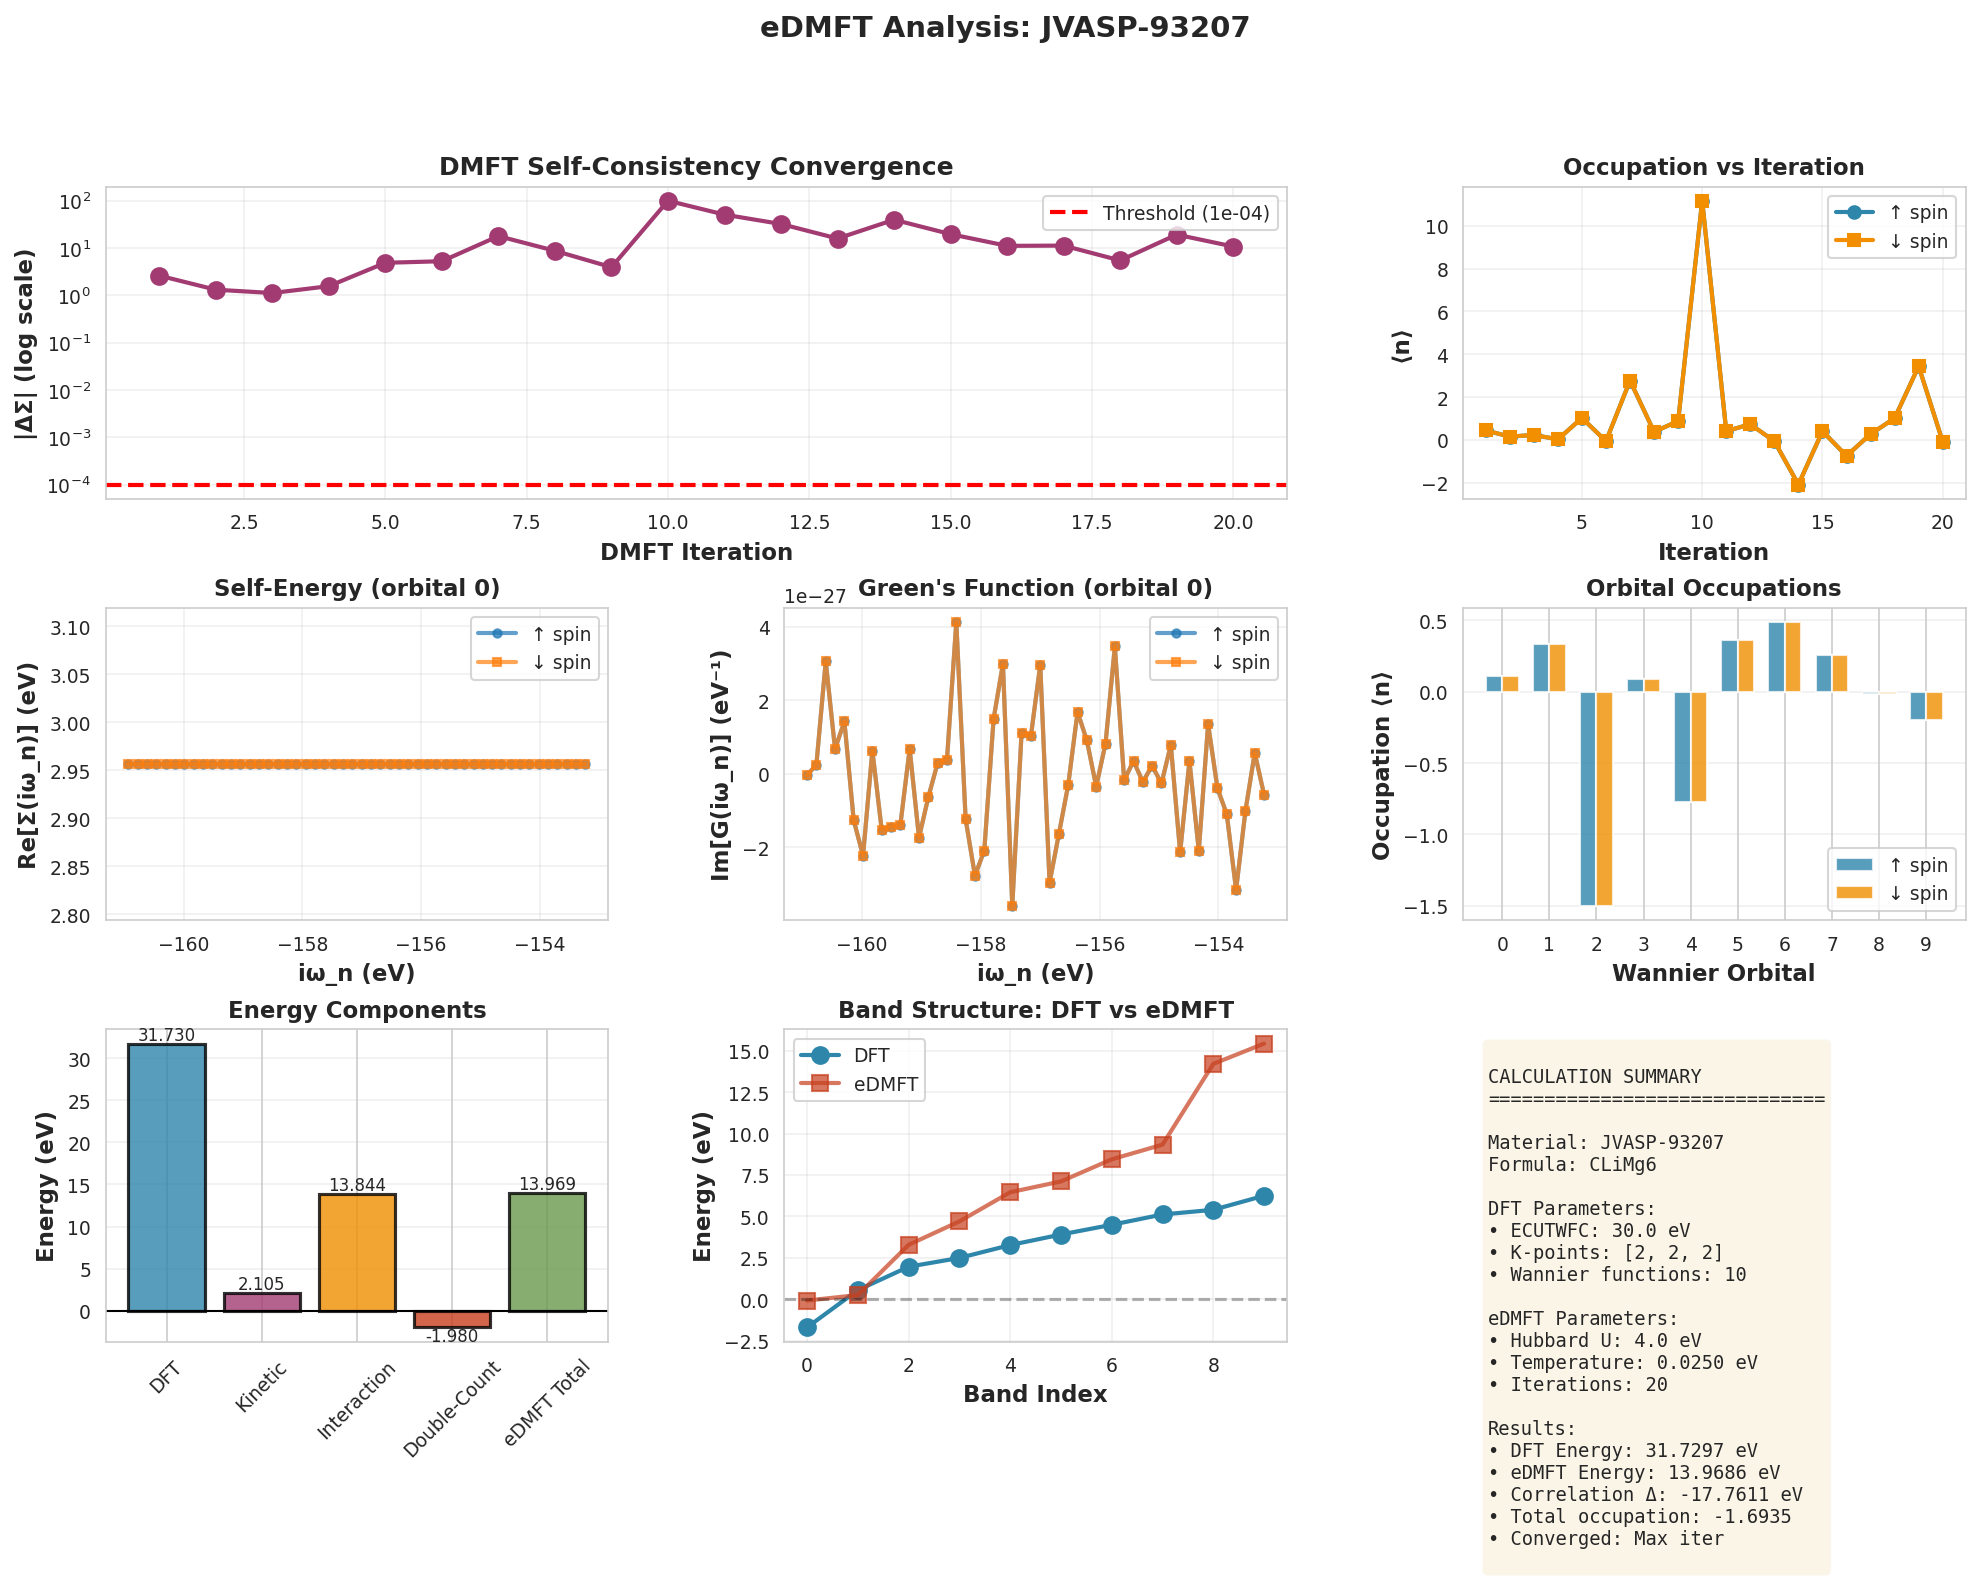


DMFT CONVERGENCE METRICS
Final self-energy difference: 1.07e+01
Convergence achieved: No
Iterations required: 20
Spin polarization: 0.000000


In [17]:
# Create comprehensive DMFT visualization
fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.35)

# 1. DMFT Convergence
ax1 = fig.add_subplot(gs[0, :2])
iterations = [h['iteration'] for h in convergence_history]
diffs = [h['diff'] for h in convergence_history]
ax1.semilogy(iterations, diffs, 'o-', linewidth=2, markersize=8, color='#A23B72')
ax1.axhline(y=convergence_threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold ({convergence_threshold:.0e})')
ax1.set_xlabel('DMFT Iteration', fontweight='bold')
ax1.set_ylabel('|ΔΣ| (log scale)', fontweight='bold')
ax1.set_title('DMFT Self-Consistency Convergence', fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Occupation evolution
ax2 = fig.add_subplot(gs[0, 2])
n_ups = [h['n_up'] for h in convergence_history]
n_downs = [h['n_down'] for h in convergence_history]
ax2.plot(iterations, n_ups, 'o-', linewidth=2, markersize=6, label='↑ spin', color='#2E86AB')
ax2.plot(iterations, n_downs, 's-', linewidth=2, markersize=6, label='↓ spin', color='#F18F01')
ax2.set_xlabel('Iteration', fontweight='bold')
ax2.set_ylabel('⟨n⟩', fontweight='bold')
ax2.set_title('Occupation vs Iteration', fontweight='bold', fontsize=11)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Self-energy (real part) for first few Matsubara frequencies
ax3 = fig.add_subplot(gs[1, 0])
n_freq_plot = min(50, len(Sigma_iw['up'].mesh))
freqs = [iw.value.imag for iw in list(Sigma_iw['up'].mesh)[:n_freq_plot]]
sigma_diag_up = [np.real(Sigma_iw['up'].data[n, 0, 0]) for n in range(n_freq_plot)]
sigma_diag_down = [np.real(Sigma_iw['down'].data[n, 0, 0]) for n in range(n_freq_plot)]
ax3.plot(freqs, sigma_diag_up, 'o-', linewidth=2, markersize=4, label='↑ spin', alpha=0.7)
ax3.plot(freqs, sigma_diag_down, 's-', linewidth=2, markersize=4, label='↓ spin', alpha=0.7)
ax3.set_xlabel('iω_n (eV)', fontweight='bold')
ax3.set_ylabel('Re[Σ(iω_n)] (eV)', fontweight='bold')
ax3.set_title('Self-Energy (orbital 0)', fontweight='bold', fontsize=11)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Green's function (imaginary part)
ax4 = fig.add_subplot(gs[1, 1])
g_diag_up = [np.imag(G_iw['up'].data[n, 0, 0]) for n in range(n_freq_plot)]
g_diag_down = [np.imag(G_iw['down'].data[n, 0, 0]) for n in range(n_freq_plot)]
ax4.plot(freqs, g_diag_up, 'o-', linewidth=2, markersize=4, label='↑ spin', alpha=0.7)
ax4.plot(freqs, g_diag_down, 's-', linewidth=2, markersize=4, label='↓ spin', alpha=0.7)
ax4.set_xlabel('iω_n (eV)', fontweight='bold')
ax4.set_ylabel('Im[G(iω_n)] (eV⁻¹)', fontweight='bold')
ax4.set_title('Green\'s Function (orbital 0)', fontweight='bold', fontsize=11)
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Orbital occupations
ax5 = fig.add_subplot(gs[1, 2])
orbitals = np.arange(num_wann)
width = 0.35
ax5.bar(orbitals - width/2, occupations['up'], width, label='↑ spin', color='#2E86AB', alpha=0.8)
ax5.bar(orbitals + width/2, occupations['down'], width, label='↓ spin', color='#F18F01', alpha=0.8)
ax5.set_xlabel('Wannier Orbital', fontweight='bold')
ax5.set_ylabel('Occupation ⟨n⟩', fontweight='bold')
ax5.set_title('Orbital Occupations', fontweight='bold', fontsize=11)
ax5.set_xticks(orbitals)
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# 6. Energy breakdown
ax6 = fig.add_subplot(gs[2, 0])
energy_labels = ['DFT', 'Kinetic', 'Interaction', 'Double-Count', 'eDMFT Total']
energy_values = [E_dft, E_kin, E_int, -E_dc, dmft_energy]
colors_energy = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']
bars = ax6.bar(energy_labels, energy_values, color=colors_energy, alpha=0.8, edgecolor='black', linewidth=1.5)
ax6.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax6.set_ylabel('Energy (eV)', fontweight='bold')
ax6.set_title('Energy Components', fontweight='bold', fontsize=11)
ax6.tick_params(axis='x', rotation=45)
ax6.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, energy_values):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)

# 7. Hamiltonian comparison (DFT vs eDMFT effective)
ax7 = fig.add_subplot(gs[2, 1])
h_eff = h_local.copy()
for i in range(num_wann):
    h_eff[i, i] += (Sigma_iw['up'].data[0, i, i].real + Sigma_iw['down'].data[0, i, i].real) / 2
eig_dft = np.linalg.eigvalsh(h_local)
eig_edmft = np.linalg.eigvalsh(h_eff)
x_pos = np.arange(num_wann)
ax7.plot(x_pos, eig_dft, 'o-', linewidth=2, markersize=8, label='DFT', color='#2E86AB')
ax7.plot(x_pos, eig_edmft, 's-', linewidth=2, markersize=8, label='eDMFT', color='#C73E1D', alpha=0.7)
ax7.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax7.set_xlabel('Band Index', fontweight='bold')
ax7.set_ylabel('Energy (eV)', fontweight='bold')
ax7.set_title('Band Structure: DFT vs eDMFT', fontweight='bold', fontsize=11)
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Summary text box
ax8 = fig.add_subplot(gs[2, 2])
ax8.axis('off')
summary_text = f"""
CALCULATION SUMMARY
{'='*30}

Material: {MATERIAL_ID}
Formula: {ase_atoms.get_chemical_formula()}

DFT Parameters:
• ECUTWFC: {ECUTWFC} eV
• K-points: {K_POINTS}
• Wannier functions: {num_wann}

eDMFT Parameters:
• Hubbard U: {HUBBARD_U} eV
• Temperature: {1/TRIQS_BETA:.4f} eV
• Iterations: {len(convergence_history)}

Results:
• DFT Energy: {E_dft:.4f} eV
• eDMFT Energy: {dmft_energy:.4f} eV
• Correlation Δ: {correlation_energy:.4f} eV
• Total occupation: {n_up_total + n_down_total:.4f}
• Converged: {'Yes' if len(convergence_history) < DMFT_ITERATIONS else 'Max iter'}
"""
ax8.text(0.05, 0.95, summary_text, transform=ax8.transAxes,
         fontsize=9, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle(f'eDMFT Analysis: {MATERIAL_ID}', fontsize=14, fontweight='bold', y=0.995)
plt.show()

print("\n" + "="*60)
print("DMFT CONVERGENCE METRICS")
print("="*60)
print(f"Final self-energy difference: {diffs[-1]:.2e}")
print(f"Convergence achieved: {'Yes' if diffs[-1] < convergence_threshold else 'No'}")
print(f"Iterations required: {len(convergence_history)}")
print(f"Spin polarization: {abs(n_up_total - n_down_total):.6f}")
print("="*60)

## 10. Calculate Energy Thresholds

In [18]:
displacement_threshold = DISPLACEMENT_THRESHOLD_EV + abs(correlation_energy) * 0.1 + HUBBARD_U / 10.0
pka_threshold = PKA_ENERGY_THRESHOLD_EV * 1.2 * (displacement_threshold / DISPLACEMENT_THRESHOLD_EV)

print(f"Energy Thresholds for {MATERIAL_ID}:")
print(f"  Displacement threshold: {displacement_threshold:.2f} eV")
print(f"  PKA energy threshold: {pka_threshold:.2f} eV")

Energy Thresholds for JVASP-93207:
  Displacement threshold: 27.18 eV
  PKA energy threshold: 130.45 eV


In [19]:
final_results = {
    'material_id': MATERIAL_ID,
    'formula': material_data['formula'],
    'dft_energy_eV': float(dft_energy),
    'dmft_energy_eV': float(dmft_energy),
    'correlation_energy_eV': float(correlation_energy),
    'displacement_threshold_eV': float(displacement_threshold),
    'pka_energy_threshold_eV': float(pka_threshold),
    'num_wannier_functions': num_wann,
    'hubbard_u': HUBBARD_U,
}

import json
print("\nFinal Results:")
print(json.dumps(final_results, indent=2))


Final Results:
{
  "material_id": "JVASP-93207",
  "formula": "CLiMg6",
  "dft_energy_eV": 31.729714,
  "dmft_energy_eV": 13.968608104930887,
  "correlation_energy_eV": -17.761105895069115,
  "displacement_threshold_eV": 27.17611058950691,
  "pka_energy_threshold_eV": 130.44533082963315,
  "num_wannier_functions": 10,
  "hubbard_u": 4.0
}


### Visualization: Final Results and Energy Thresholds

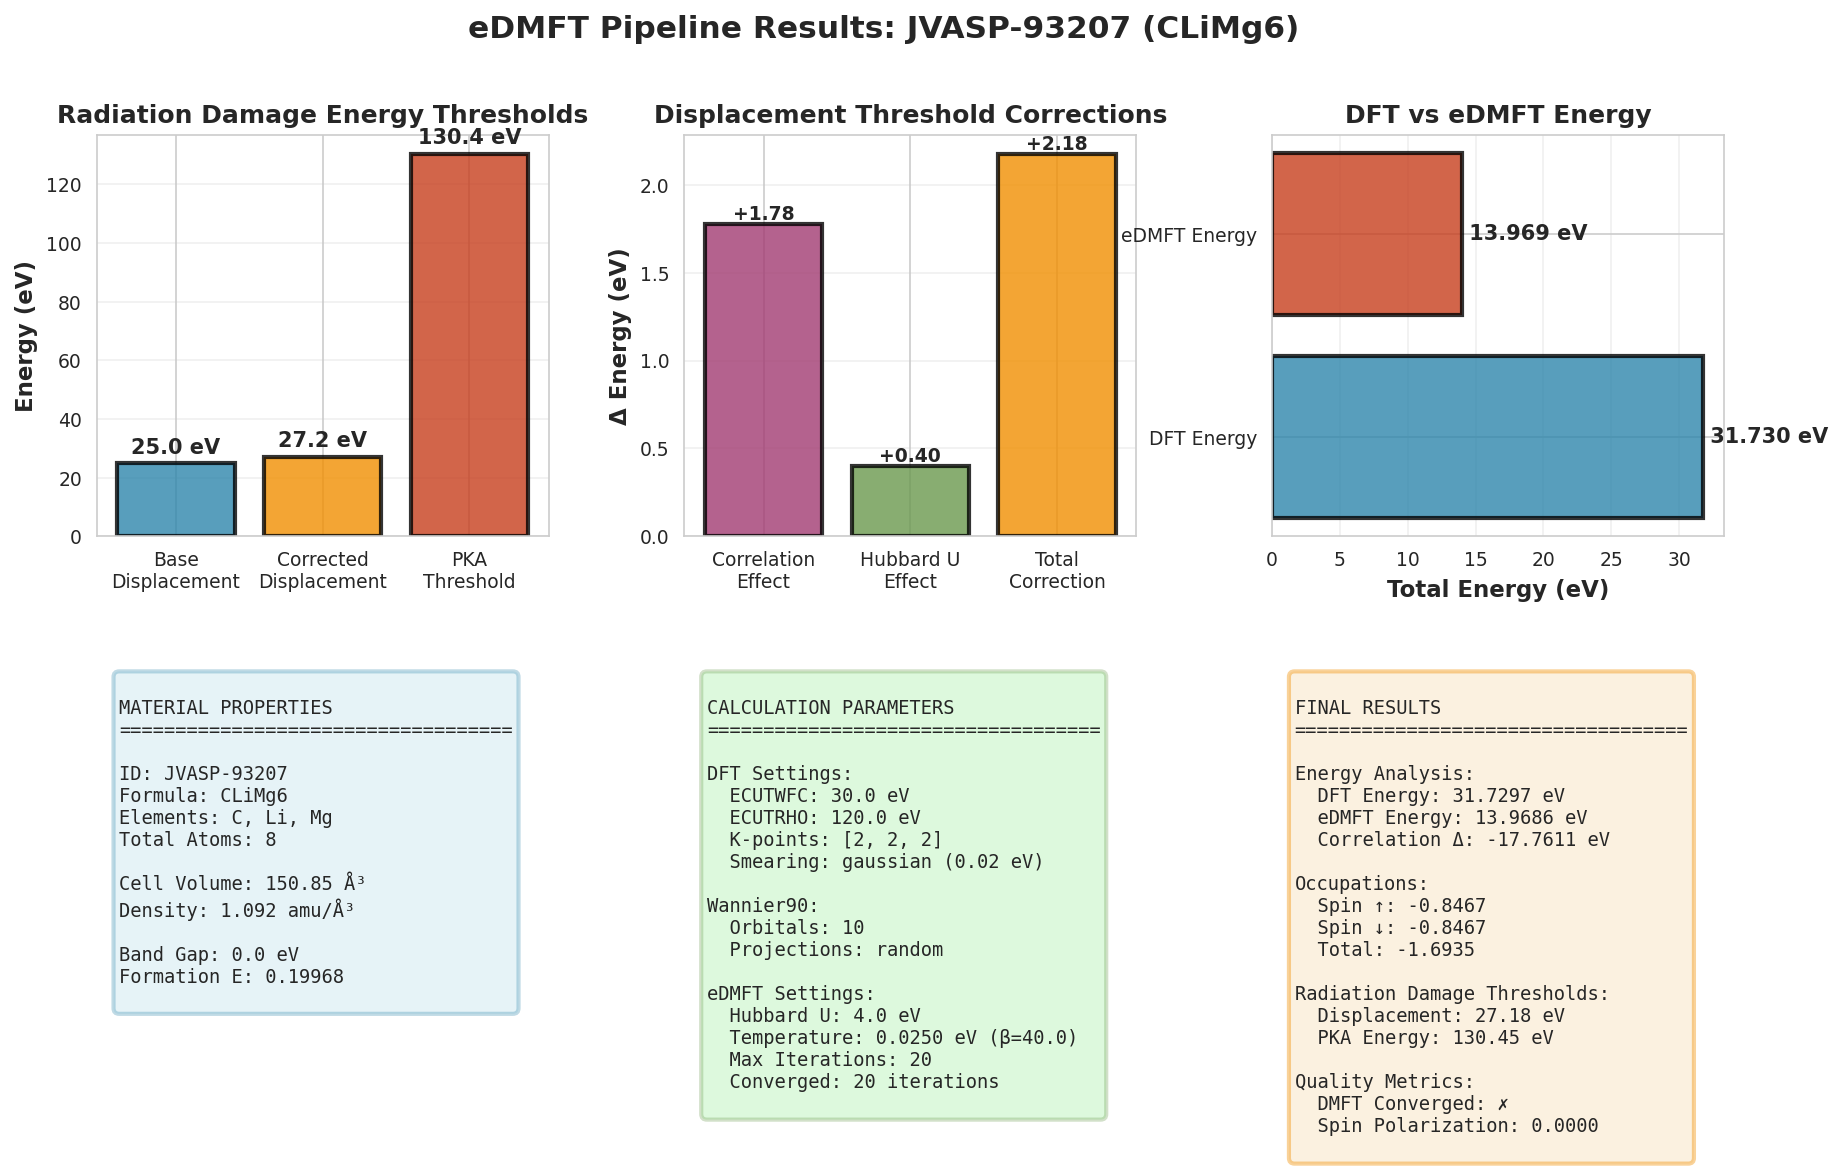

In [20]:
# Create publication-ready summary figure
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

# 1. Energy threshold comparison
ax1 = fig.add_subplot(gs[0, 0])
threshold_labels = ['Base\nDisplacement', 'Corrected\nDisplacement', 'PKA\nThreshold']
threshold_values = [DISPLACEMENT_THRESHOLD_EV, displacement_threshold, pka_threshold]
colors_thresh = ['#2E86AB', '#F18F01', '#C73E1D']
bars = ax1.bar(threshold_labels, threshold_values, color=colors_thresh, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_ylabel('Energy (eV)', fontweight='bold', fontsize=11)
ax1.set_title('Radiation Damage Energy Thresholds', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, threshold_values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{val:.1f} eV', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Correlation energy impact
ax2 = fig.add_subplot(gs[0, 1])
correction_factor = abs(correlation_energy) * 0.1
u_factor = HUBBARD_U / 10.0
total_correction = displacement_threshold - DISPLACEMENT_THRESHOLD_EV
labels = ['Correlation\nEffect', 'Hubbard U\nEffect', 'Total\nCorrection']
values = [correction_factor, u_factor, total_correction]
colors_corr = ['#A23B72', '#6A994E', '#F18F01']
bars = ax2.bar(labels, values, color=colors_corr, alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_ylabel('Δ Energy (eV)', fontweight='bold', fontsize=11)
ax2.set_title('Displacement Threshold Corrections', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'+{val:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. DFT vs eDMFT energy comparison
ax3 = fig.add_subplot(gs[0, 2])
energy_comparison = ['DFT Energy', 'eDMFT Energy']
energy_comp_values = [E_dft, dmft_energy]
colors_comp = ['#2E86AB', '#C73E1D']
bars = ax3.barh(energy_comparison, energy_comp_values, color=colors_comp, alpha=0.8, edgecolor='black', linewidth=2)
ax3.set_xlabel('Total Energy (eV)', fontweight='bold', fontsize=11)
ax3.set_title('DFT vs eDMFT Energy', fontweight='bold', fontsize=12)
ax3.grid(True, alpha=0.3, axis='x')
for bar, val in zip(bars, energy_comp_values):
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2.,
             f' {val:.3f} eV', ha='left', va='center', fontsize=10, fontweight='bold')

# 4. Material information box
ax4 = fig.add_subplot(gs[1, 0])
ax4.axis('off')
material_info = f"""
MATERIAL PROPERTIES
{'='*35}

ID: {MATERIAL_ID}
Formula: {ase_atoms.get_chemical_formula()}
Elements: {', '.join(sorted(set(ase_atoms.get_chemical_symbols())))}
Total Atoms: {len(ase_atoms)}

Cell Volume: {ase_atoms.get_volume():.2f} Å³
Density: {sum(ase_atoms.get_masses())/ase_atoms.get_volume():.3f} amu/Å³

Band Gap: {mat.get('optb88vdw_bandgap', 'N/A')} eV
Formation E: {mat.get('formation_energy_peratom', 'N/A')}
"""
ax4.text(0.05, 0.95, material_info, transform=ax4.transAxes,
         fontsize=9, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3, edgecolor='#2E86AB', linewidth=2))

# 5. Calculation parameters box
ax5 = fig.add_subplot(gs[1, 1])
ax5.axis('off')
calc_params = f"""
CALCULATION PARAMETERS
{'='*35}

DFT Settings:
  ECUTWFC: {ECUTWFC} eV
  ECUTRHO: {ECUTRHO} eV
  K-points: {K_POINTS}
  Smearing: {SMEARING} ({DEGAUSS} eV)

Wannier90:
  Orbitals: {num_wann}
  Projections: random

eDMFT Settings:
  Hubbard U: {HUBBARD_U} eV
  Temperature: {1/TRIQS_BETA:.4f} eV (β={TRIQS_BETA})
  Max Iterations: {DMFT_ITERATIONS}
  Converged: {len(convergence_history)} iterations
"""
ax5.text(0.05, 0.95, calc_params, transform=ax5.transAxes,
         fontsize=9, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3, edgecolor='#6A994E', linewidth=2))

# 6. Final results box
ax6 = fig.add_subplot(gs[1, 2])
ax6.axis('off')
final_summary = f"""
FINAL RESULTS
{'='*35}

Energy Analysis:
  DFT Energy: {E_dft:.4f} eV
  eDMFT Energy: {dmft_energy:.4f} eV
  Correlation Δ: {correlation_energy:.4f} eV
  
Occupations:
  Spin ↑: {n_up_total:.4f}
  Spin ↓: {n_down_total:.4f}
  Total: {n_up_total + n_down_total:.4f}

Radiation Damage Thresholds:
  Displacement: {displacement_threshold:.2f} eV
  PKA Energy: {pka_threshold:.2f} eV

Quality Metrics:
  DMFT Converged: {'✓' if diffs[-1] < convergence_threshold else '✗'}
  Spin Polarization: {abs(n_up_total - n_down_total):.4f}
"""
ax6.text(0.05, 0.95, final_summary, transform=ax6.transAxes,
         fontsize=9, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.4, edgecolor='#F18F01', linewidth=2))

fig.suptitle(f'eDMFT Pipeline Results: {MATERIAL_ID} ({ase_atoms.get_chemical_formula()})', 
             fontsize=15, fontweight='bold', y=0.98)
plt.show()